# Setup

In [2]:
%load_ext autoreload
%autoreload 2
%aimport

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Modules to reload:
all-except-skipped

Modules to skip:



In [3]:
%matplotlib inline

In [4]:
import sys
sys.path.append('/home/imendoza/nbody-relaxed/')

In [49]:
# import astropy
import numpy as np
import matplotlib.pyplot as plt 
plt.rcParams.update({
    "text.usetex": True,})


In [7]:
from relaxed.analysis import get_mah, get_t_from_a, alpha_diffmah, diffmah_analysis

# Data

In [8]:
mah_data = get_mah('m12', '../../output/', cutoff_missing=0.05, cutoff_particle=0.05)

In [9]:
ma_peak = mah_data['ma_peak']
mpeak =mah_data['mpeak']
scales = mah_data['scales']
t = get_t_from_a(scales)
t0 = get_t_from_a(1)

# Lmfit

In [39]:
lm_tau_c, lm_alpha_early, lm_alpha_late = diffmah_analysis(ma_peak, scales)

Fitting Diffmah parameters: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:07<00:00, 147.96it/s]


[6048 2763 1203 4704 7738 2676 5886 1046 1627]


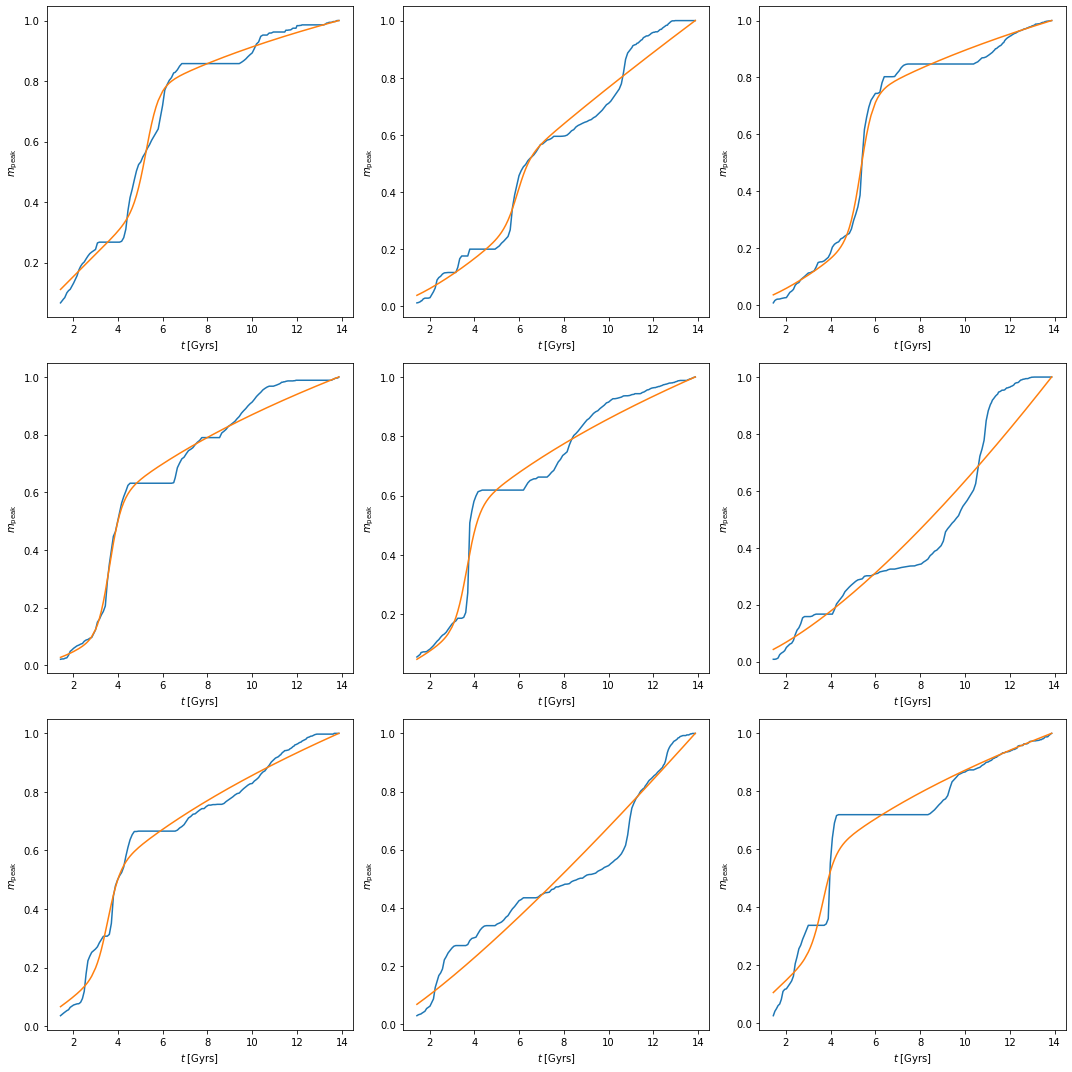

In [16]:
indices = np.random.randint(0, 10000, 9)
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
print(indices)
for idx, ax in zip(indices, axes.flatten()): 
    pred = (t/t0)**(alpha_diffmah(t, lm_tau_c[idx], lm_alpha_early[idx], lm_alpha_late[idx]))
    ax.plot(t, ma_peak[idx])
    ax.plot(t, pred)
    ax.set_xlabel(r"$t \; [\rm Gyrs]$")
    ax.set_ylabel(r"$m_{\rm peak}$")
plt.tight_layout()

Text(0.5, 0, '$\\log \\tau_{c} \\; [\\rm Gyr]$')

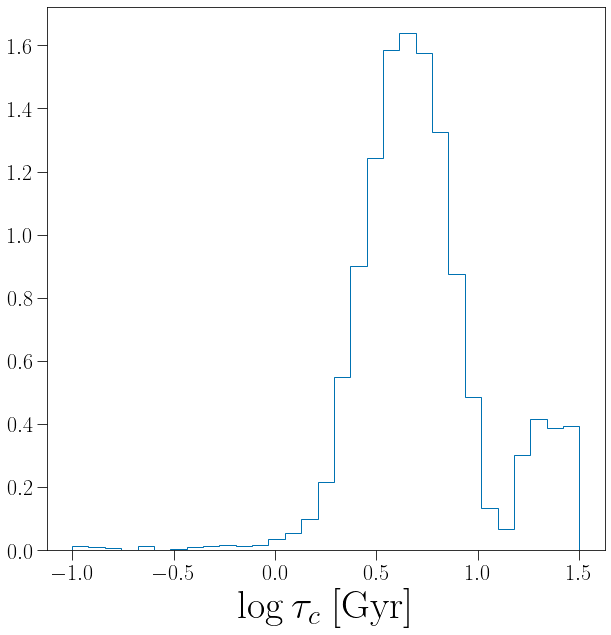

In [51]:
plt.hist(np.log10(tau_c), range=(-1, 1.5), bins=31, density=True, histtype='step')
plt.xlabel(r"$\log \tau_{c} \; [\rm Gyr]$", fontsize=40)

# Diffmah directly

In [10]:
from diffmah.fit_mah_helpers import get_loss_data
from diffmah.fit_mah_helpers import log_mah_mse_loss_and_grads
from diffmah.utils import jax_adam_wrapper
from diffmah.measure_mahs import get_clean_sample_mask

/home/imendoza/.cache/pypoetry/virtualenvs/nbody-relaxed-NAcJ5UAP-py3.8/lib/python3.8/site-packages/jax/experimental/optimizers.py:28: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  warnings.warn('jax.experimental.optimizers is deprecated, '


In [12]:
mah_data = get_mah("m12", "../../output", cutoff_missing=0.05, cutoff_particle=0.05)

ma_peak = mah_data["ma_peak"]
mpeak = mah_data["mpeak"]
scales = mah_data["scales"]
t = get_t_from_a(scales)
t0 = get_t_from_a(1)

log_mah = np.log10(ma_peak * mpeak.reshape(-1, 1))
log_min_mass = np.log10(100 * 1.35e8)

In [19]:
from tqdm import tqdm 

fit_params = []
for ii in tqdm(range(0, 1)):
    n_steps = 200
    lma_i = log_mah[ii, :]
    p_init, loss_data = get_loss_data(t, lma_i, log_min_mass)
    _res = jax_adam_wrapper(log_mah_mse_loss_and_grads, p_init, loss_data, n_steps, n_warmup=1)
    p_best, loss, loss_arr, params_arr, fit_terminates = _res
    fit_params.append(tuple(p_best))
fit_params = np.array(fit_params)

100%|██████████| 99/99 [01:05<00:00,  1.52it/s]


## Plots

In [31]:
# params[0] = log10(tau_c)
# params[1] = ue = U(alpha_early - alpha_late)
# params[2] = ul = U(late)
params = np.load('../../output/pbest_diffmah.npy')

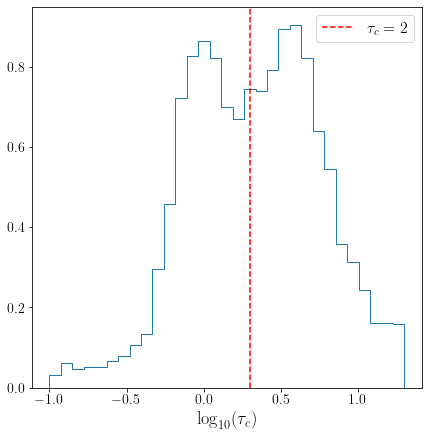

In [50]:
plt.figure(figsize=(7,7))
n, bins, patches = plt.hist(params[:, 0], histtype='step', bins=31, range=(-1.0, 1.3), density=True)
plt.axvline(np.log10(2), label=r"$\tau_{c} = 2$", color='r', ls='--')
plt.xlabel(r"$\log_{10}(\tau_{c})$", size=18)
plt.legend(prop={'size':16})
plt.tick_params('both', labelsize=14)


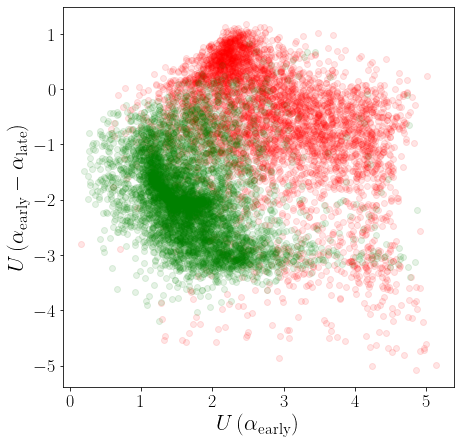

In [63]:
from relaxed.analysis import softplus, inv_softplus
plt.figure(figsize=(7,7))
u_a_late = params[:, 2]
u_a_early = inv_softplus(softplus(params[:, 1]) + softplus(u_a_late))


plt.scatter(u_a_early[10**params[:, 0]< 2], params[:, 2][10**params[:, 0] < 2], alpha=0.1, color='r')
plt.scatter(u_a_early[10**params[:, 0]>2], params[:, 2][10**params[:, 0] > 2], alpha=0.1, color='g')
plt.xlabel(r"$U\left(\alpha_{\rm early} \right)$", size=22)
plt.ylabel(r"$U\left(\alpha_{\rm early} - \alpha_{\rm late} \right)$", size=22)

plt.tick_params('both', labelsize=18)

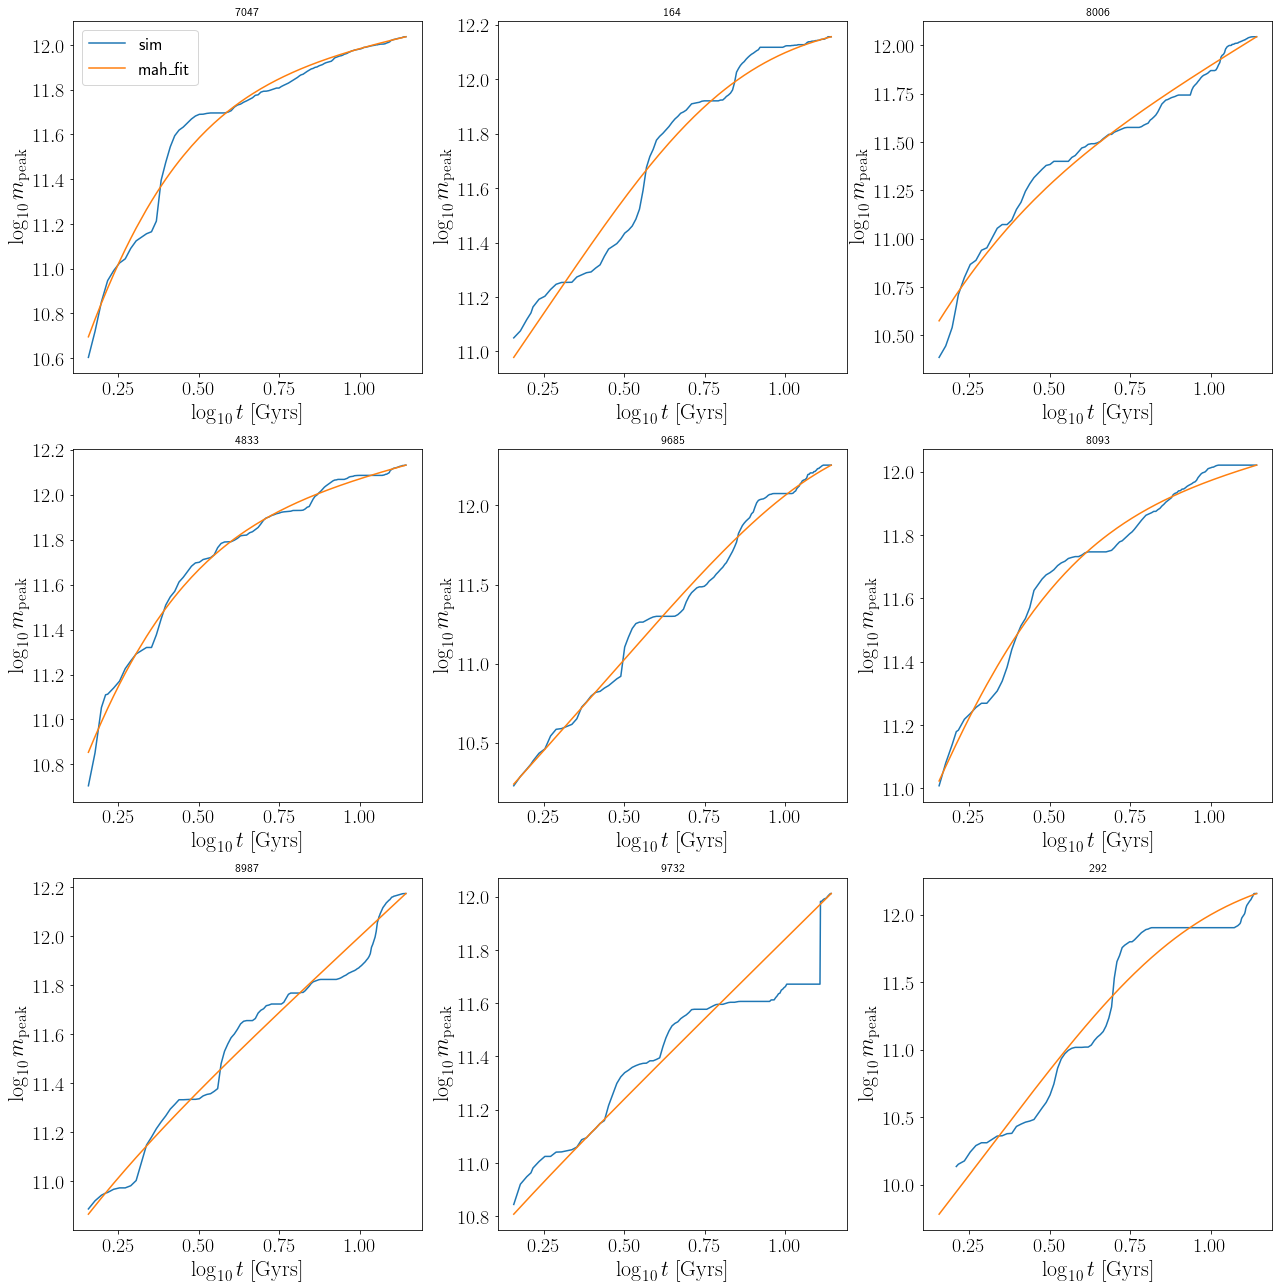

In [65]:
from diffmah.individual_halo_assembly import _get_early_late
from diffmah.individual_halo_assembly import _calc_halo_history


indices = np.random.randint(0, len(params), 9)
fig, axes = plt.subplots(3, 3, figsize=(18, 18))

for ii, (idx, ax) in enumerate(zip(indices, axes.flatten())):
    logtc, ue, ul = params[idx, 0], params[idx, 1], params[idx, 2]
    
    p_init, loss_data = get_loss_data(t, log_mah[idx, :], log_min_mass)
    logt_target, log_mah_target, logtmp, k, logmp_fit = loss_data
    early, late = _get_early_late(ue, ul)

    logt = np.log10(t)
    dmhdt_fit, log_mah_fit = _calc_halo_history(logt, logt[-1], logmp_fit, logtc, 3.5, early, late)

    
    # lmfit_log_mah_fit = np.log10((t/t0)**(alpha_diffmah(t, tau_c2[idx], alpha_early2[idx], alpha_late2[idx])) * mpeak[idx])

    
    ax.plot(logt_target, log_mah_target, label='sim')
    ax.plot(logt, log_mah_fit, label='mah_fit')
    # ax.plot(logt, lmfit_log_mah_fit, label='lmfit')
    ax.set_xlabel(r"$\log_{10} t \; [\rm Gyrs]$", size=22)
    ax.set_ylabel(r"$\log_{10} m_{\rm peak}$", size=22)
    ax.set_title(idx)
    if ii == 0: 
        ax.legend(prop=dict(size=18), loc='best')
    ax.tick_params(axis='both', labelsize=20)
plt.tight_layout()

